In [2]:
import pandas as pd
from datasets import Dataset, DatasetDict
from setfit import SetFitModel, SetFitTrainer
from sklearn.metrics import classification_report

c:\Users\Eric\miniconda3\envs\PDS_new\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_df = pd.read_csv("../final/classified_output_v3.csv")
test_df = pd.read_csv("../final/highest_active_jobs.csv")


train_df.rename(columns={"predicted_seniority": "label"}, inplace=True)
test_df.rename(columns={"seniority": "label", "position": "text"}, inplace=True)

In [ ]:
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_ds,
    "test": test_ds
})

dataset = dataset.class_encode_column("label")

label_names = dataset["train"].features["label"].names

model = SetFitModel.from_pretrained(
    #"BAAI/bge-m3",
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    labels=label_names,
    device="cuda" 
)

trainer = SetFitTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    metric="accuracy",
    batch_size=16,
    num_iterations=20,
    num_epochs=1,
)

trainer.train()
metrics = trainer.evaluate()
print(f"Metrics: {metrics}")


Casting to class labels: 100%|██████████| 478/478 [00:00<00:00, 95606.93 examples/s]
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
C:\Users\Eric\AppData\Local\Temp\ipykernel_17948\1114541806.py:38: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Map: 100%|██████████| 362/362 [00:00<00:00, 42568.63 examples/s]
***** Running training *****
  Num unique pairs = 14480
  Batch size = 16
  Num epochs = 1
c:\Users\Eric\miniconda3\envs\PDS_new\Lib\site-packages\torch\utils\data\_utils\pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.pin_memory() is deprecated. Please do not pass this argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Memory.cpp:48.)
  return data.pin_memory(de

Step,Training Loss
1,0.313200
50,0.251800
100,0.206800
150,0.129900
200,0.075300
250,0.036500
300,0.015600
350,0.012400
400,0.009500
450,0.003800


c:\Users\Eric\miniconda3\envs\PDS_new\Lib\site-packages\torch\utils\data\_utils\pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.pin_memory() is deprecated. Please do not pass this argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Memory.cpp:48.)
  return data.pin_memory(device)
c:\Users\Eric\miniconda3\envs\PDS_new\Lib\site-packages\torch\utils\data\_utils\pin_memory.py:57: DeprecationWarning: The argument 'device' of Tensor.is_pinned() is deprecated. Please do not pass this argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Memory.cpp:33.)
  return data.pin_memory(device)
***** Running evaluation *****


Metrics: {'accuracy': 0.8472803347280334}


In [ ]:
print("Generating report...")

preds = model.predict(dataset["test"]["text"])

label_names = dataset["test"].features["label"].names
y_true = [label_names[i] for i in dataset["test"]["label"]]

print(classification_report(y_true, preds))

Generating report...
              precision    recall  f1-score   support

    Director       0.91      0.87      0.89        23
      Junior       1.00      0.12      0.22         8
        Lead       0.88      0.78      0.83        89
  Management       0.85      0.92      0.88       150
Professional       0.80      0.88      0.84       167
      Senior       1.00      0.73      0.85        41

    accuracy                           0.85       478
   macro avg       0.91      0.72      0.75       478
weighted avg       0.86      0.85      0.84       478



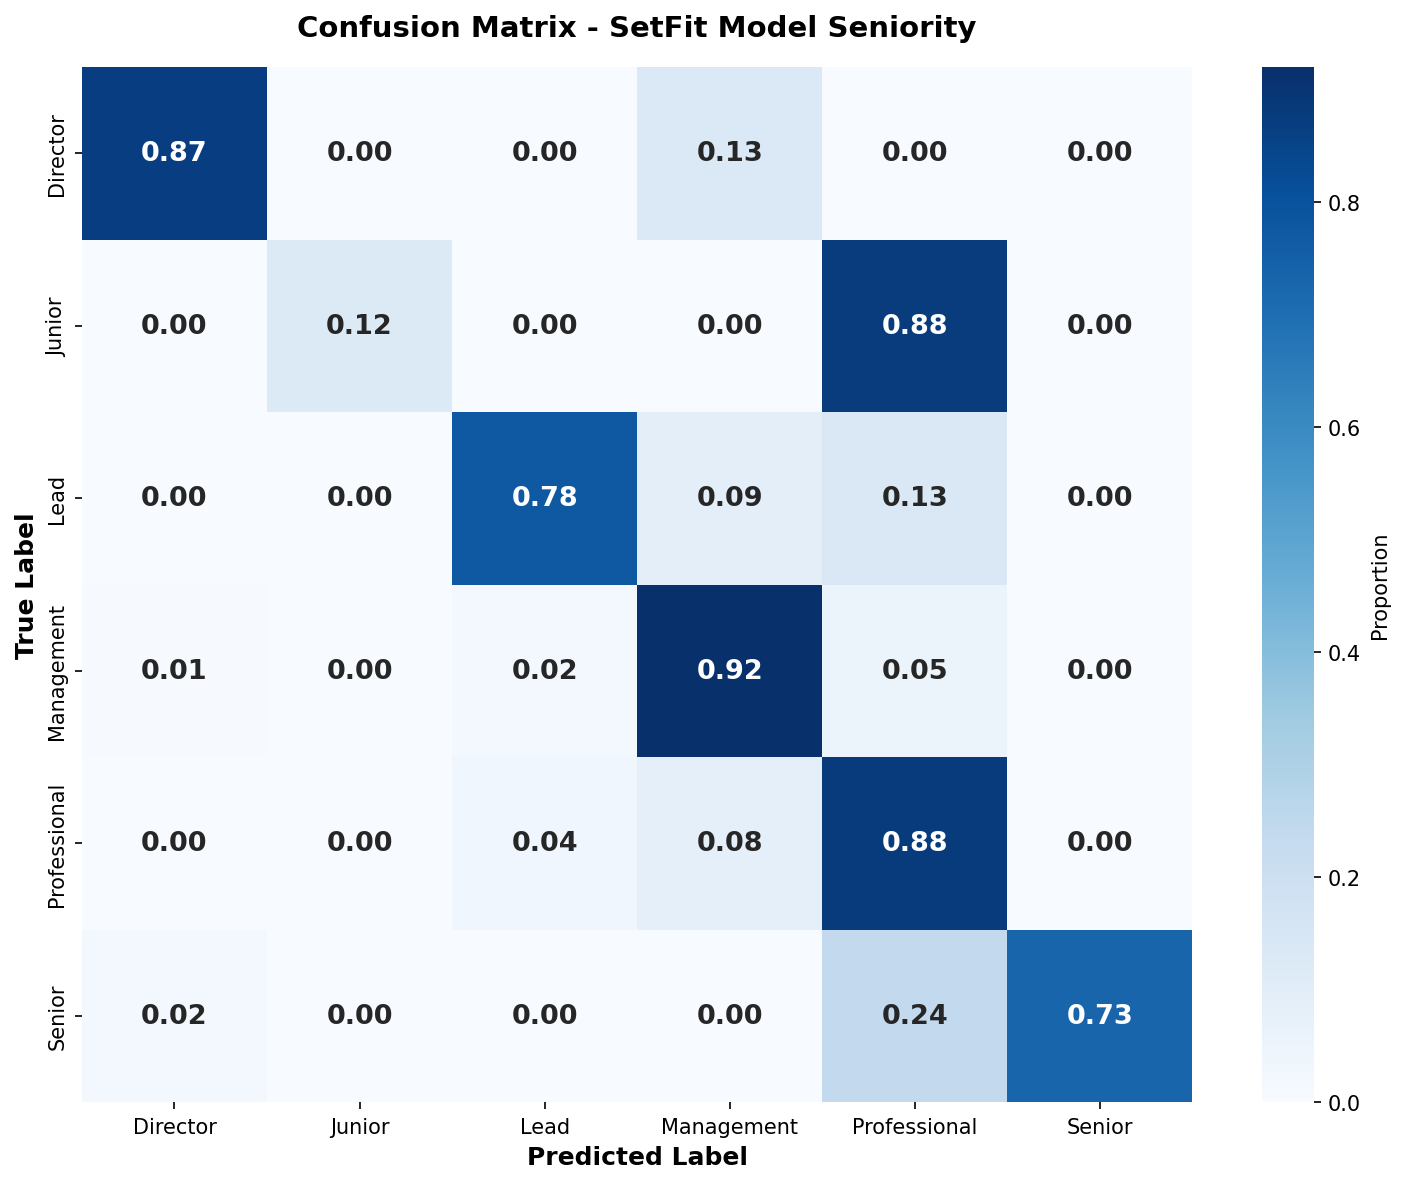


Confusion Matrix:
[[ 20   0   0   3   0   0]
 [  0   1   0   0   7   0]
 [  0   0  69   8  12   0]
 [  1   0   3 138   8   0]
 [  0   0   6  14 147   0]
 [  1   0   0   0  10  30]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, preds, labels=label_names)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8), dpi=150)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Proportion'},
            annot_kws={'size': 13, 'weight': 'bold'})
plt.title('Confusion Matrix - SetFit Model Seniority', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfusion Matrix:\n{cm}")